<h1>Data Preparation with PyTorch</h1>

<p>Crack detection has vital importance for structural health monitoring and inspection. We would like to train a network to detect Cracks, we will denote the images that contain cracks as positive and images with no cracks as negative.  In this lab you are going to have to build a dataset object. There are five questions in this lab, Including some questions that are intermediate steps to help you build the dataset object. You are going to have to remember the output for some  of the questions. </p>

<h2 id="download_data">Download Data</h2>

In this section, you are going to download the data from IBM object storage using <b>wget</b>, then unzip them.  <b>wget</b> is a command the retrieves content from web servers, in this case its a zip file. Locally we store the data in the directory  <b>/resources/data</b> . The <b>-p</b> creates the entire directory tree up to the given directory.

First, we download the file that contains the images, if you dint do this in your first lab uncomment:

In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip

--2020-09-09 17:49:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245259777 (234M) [application/zip]
Saving to: ‘concrete_crack_images_for_classification.zip.2’

100%[======================================>] 245,259,777 47.5MB/s   in 5.0s   

2020-09-09 17:49:43 (46.9 MB/s) - ‘concrete_crack_images_for_classification.zip.2’ saved [245259777/245259777]



We then unzip the file, this ma take a while:

In [2]:
!unzip -n concrete_crack_images_for_classification.zip

Archive:  concrete_crack_images_for_classification.zip


We then download the files that contain the negative images:

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab:

In [3]:
!pip install torch
!pip install torchvision

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

We will use this function in the lab to plot:

In [5]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

<h2 id="examine_files">Examine Files </h2>

In the previous lab, we create two lists; one to hold the path to the Negative files and one to hold the path to the Positive files. This process is shown in the following few lines of code.

We can obtain the list that contains the path to the <b>negative files</b> as follows:

In [6]:
#directory="/resources/data"
negative='./Negative'
negative_file_path=os.path.join(negative)
negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
negative_files.sort()
negative_files[0:3]

['./Negative/00001.jpg', './Negative/00002.jpg', './Negative/00003.jpg']

We can obtain the list that contains the path to the <b>positive files</b> files as follows:

In [7]:
positive="./Positive"
positive_file_path=os.path.join(positive)
positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
positive_files.sort()
positive_files[0:3]

['./Positive/00001.jpg', './Positive/00002.jpg', './Positive/00003.jpg']

<h2 id="Question_1">Question 1</h2>
<b>Find the <b>combined</b> length of the list <code>positive_files</code> and <code>negative_files</code> using the function <code>len</code> . Then assign  it to the variable <code>number_of_samples</code></b>

In [8]:
number_of_samples = len(positive_files) + len(negative_files)
number_of_samples

40000

<h2 id="assign_labels">Assign Labels to Images </h2>

In this section we will assign a label to each image in this case we  can assign the positive images, i.e images with a crack to a value one  and the negative images i.e images with out a crack to a value of zero <b>Y</b>. First we create a tensor or vector of zeros, each element corresponds to a new sample. The length of the tensor is equal to the number of samples.

In [9]:
Y=torch.zeros([number_of_samples])

As we are using the tensor <b>Y</b> for classification we cast it to a <code>LongTensor</code>. 

In [10]:
Y=Y.type(torch.LongTensor)
Y.type()

'torch.LongTensor'

With respect to each element we will set the even elements to class one and the odd elements to class zero.

In [11]:
Y[::2] = 1
Y[1::2]= 0
Y[0:10]

tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

<h2 id="Question_2">Question 2</h2>
<b>Create a list all_files such that the even indexes contain the path to images with positive or cracked samples and the odd element contain the negative images or images with out cracks. Then use the following code to print out the first four samples.</b>

In [12]:
all_files = [None]*(len(positive_files)+len(negative_files))
all_files[::2] = positive_files
all_files[1::2] = negative_files
all_files[0:6]

['./Positive/00001.jpg',
 './Negative/00001.jpg',
 './Positive/00002.jpg',
 './Negative/00002.jpg',
 './Positive/00003.jpg',
 './Negative/00003.jpg']

code used to print samples:

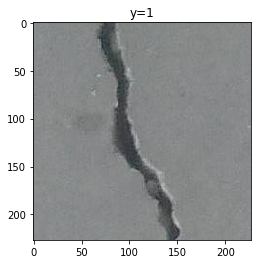

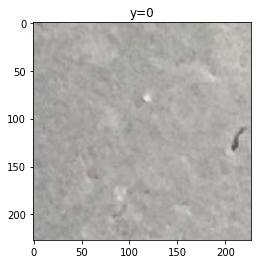

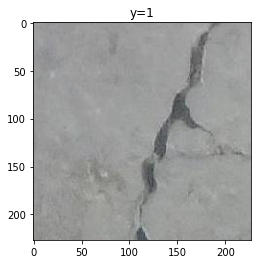

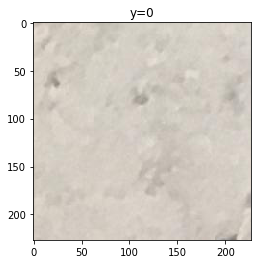

In [13]:
for y,file in zip(Y, all_files[0:4]):
    plt.imshow(Image.open(file))
    plt.title("y="+str(y.item()))
    plt.show()

<h2 id="split">Training  and Validation  Split  </h2>
When training the model we  split up our data into training and validation data. It If the variable train is set to <code>True</code>  the following lines of code will segment the  tensor <b>Y</b> such at  the first 30000 samples are used for training. If the variable train is set to <code>False</code> the remainder of the samples will be used for validation data. 

In [14]:
train=False

if train:
    all_files=all_files[0:30000]
    Y=Y[0:30000]

else:
    all_files=all_files[30000:]
    Y=Y[30000:]

<h2 id="Question_3">Question 3</h2>
Modify the above lines of code such that if the variable <code>train</code> is set to <c>True</c> the first 30000 samples of all_files are use in training. If <code>train</code> is set to <code>False</code> the remaining  samples are used for validation. In both cases reassign  the values to the variable all_files, then use the following lines of code to print out the first four validation sample images.

In [15]:
train=False

if train:
    all_files=all_files[0:30000]
    Y=Y[0:30000]

else:
    all_files=all_files[30000:]
    Y=Y[30000:]

In [16]:
for y,file in zip(Y, all_files[0:4]):
    plt.imshow(Image.open(file))
    plt.title("y="+str(y.item()))
    plt.show()

Just a note the images printed out in question two are the first four training samples.

<h2 id="data_class">Create a Dataset Class</h2>

In this section, we will use the previous code to build a dataset class. 


Complete the code to build a Dataset class <code>dataset</code>. As before, make sure the even samples are positive, and the odd samples are negative.  If the parameter <code>train</code> is set to <code>True</code>, use the first 30 000  samples as training data; otherwise, the remaining samples will be used as validation data.  

In [17]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        #directory="/resources/data"
        positive="./Positive"
        negative="./Negative"

        positive_file_path=os.path.join(positive)
        negative_file_path=os.path.join(negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()

        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:

            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:

            self.Y=self.Y[30000:]
            self.len=len(self.all_files)
    
  
            
     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="Question_4">Question 4</h2>
<b>Create a Dataset object <code>dataset</code> for the training data, use the following lines of code to print out sample the 10th and  sample 100 (remember zero indexing)  </b>

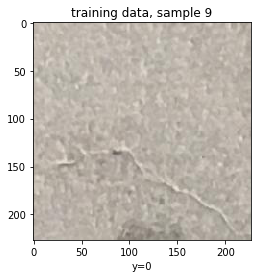

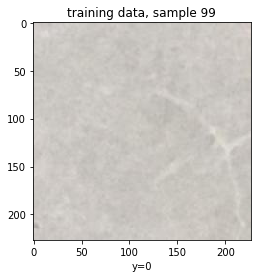

In [18]:
dataset = Dataset(transform=None,train=True)
samples = [9,99]

for sample in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("training data, sample {}".format(int(sample)))
    plt.show()

We now have all the tools to create a list with the path to each image file.  We use a List Comprehensions  to make the code more compact. We assign it to the variable <code>negative_files<code> , sort it in and display the first three elements:

<h2 id="Question_5">Question 5</h2>
<b>Create a Dataset object <code>dataset</code> for the validation  data, use the following lines of code to print out the 16 th and  sample 103 (remember zero indexing)   </b>

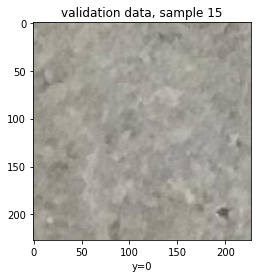

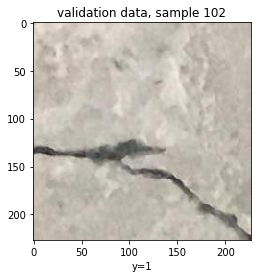

In [19]:
dataset = Dataset(transform=None,train=False)
samples = [15,102]

for sample  in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("validation data, sample {}".format(int(sample)))
    plt.show()